<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# VAEs supervisados

<i><small>Authors: Félix José Fuentes Hurtado<br>Last update: 2023-10-05</small></i></div>

***

### VAEs supervisados

En este notebook vamos a ver cómo podemos implementar un autoencoder variacional **añadiéndole un término supervisado** a la función de pérdidas.

Primero definiremos un VAE básico, para, después, añadirle un término de supervisión que actuará sobre el espacio latente.

Aquí tenéis el diagrama del VAE para que recordéis como funciona:

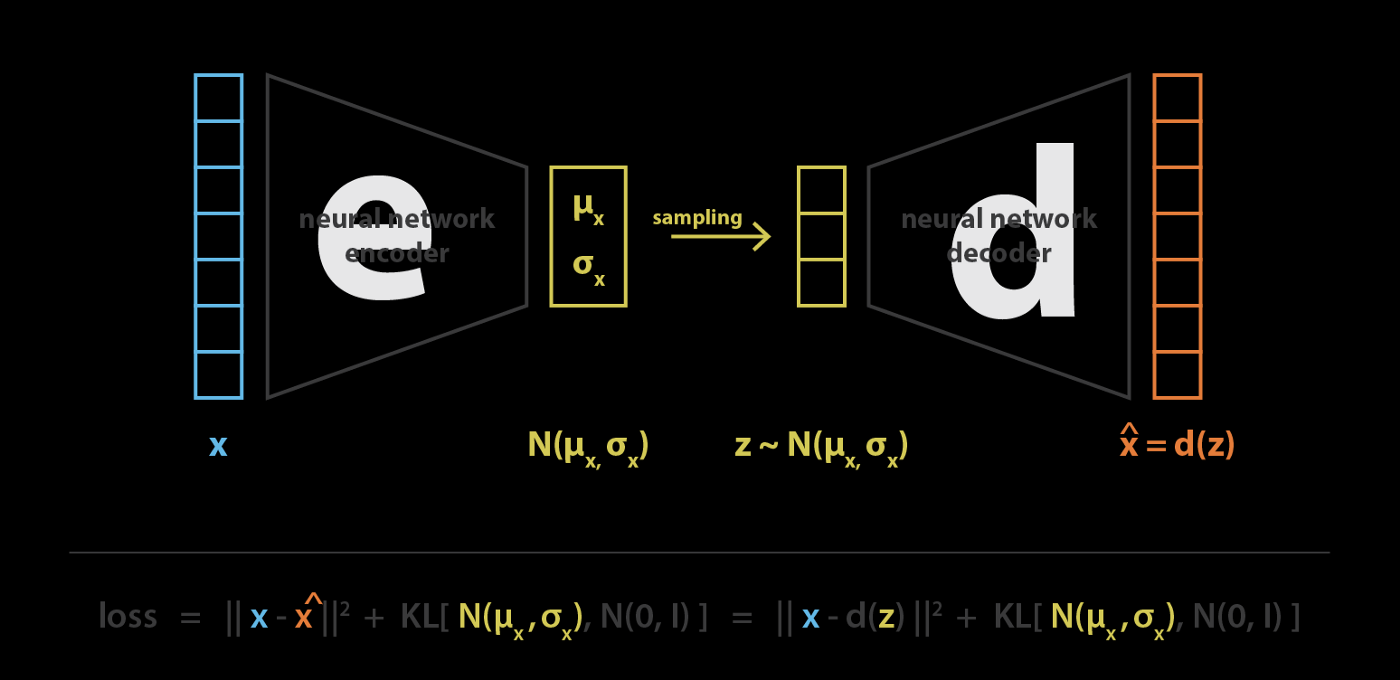

**¡Comenzemos!**

Vamos a construir el AutoEncoder Variacional más simple posible:

In [7]:
import keras
from keras import layers
from keras import backend as K

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

# encoder
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 64)                   50240     ['input_2[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 2)                    130       ['dense_7[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 2)                    130       ['dense_7[0][0]']             
                                                                                            

In [6]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
print(encoder(inputs)[2])
outputs = decoder(encoder(inputs)[2])
print(outputs)
vae = keras.Model(inputs, outputs, name='vae_mlp')

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='encoder/lambda/add:0', description="created by layer 'encoder'")
KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), name='decoder/dense_6/Sigmoid:0', description="created by layer 'decoder'")


In [5]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  50500     ['input_1[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  51152     ['encoder[0][2]']             
                                                                                            

In [3]:
# loss function
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Ya tenemos definida la arquitectura. Ahora obtendremos los datos y entrenaremos el modelo:

In [4]:
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/30
1199/1875 [==================>...........] - ETA: 1s - loss: 195.2915

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-3, 3]
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Y con esto, tenemos nuestro primer VAE implementado.

Veamos su espacio latente para recordar su apariencia:

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

### Añadiendo un término de supervisión al VAE básico

Ahora vamos a añadir un término a la función de pérdidas que intente clasificar los dígitos a partir de los valores del espacio latente. De esta forma, estamos tratando de clasificar imágenes de 28x28 pixels empleando únicamente 2 valores.

**Ejercicio**

Modifica el ejemplo anterior para que exista un término en la función de pérdidas para clasificar las imágenes de entrada empleando para ello los elementos del código latente.

Como ayuda, aquí podéis ver un diagrama del VAE tradicional:

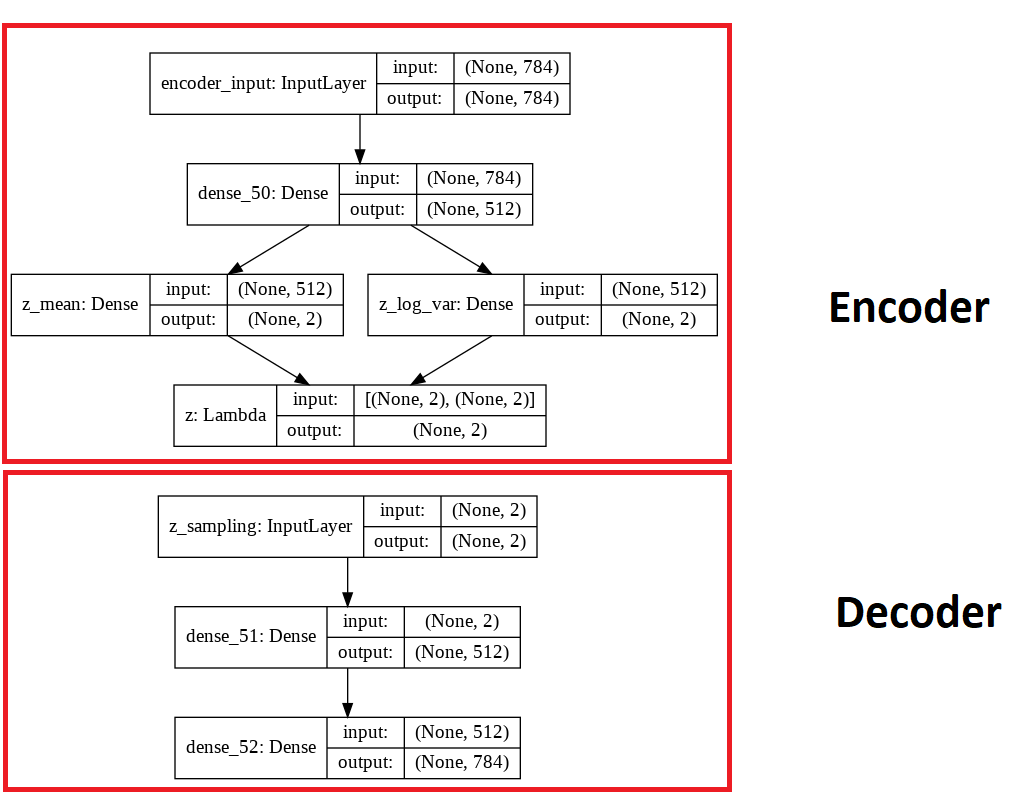

Y lo que necesitamos es lo siguiente:

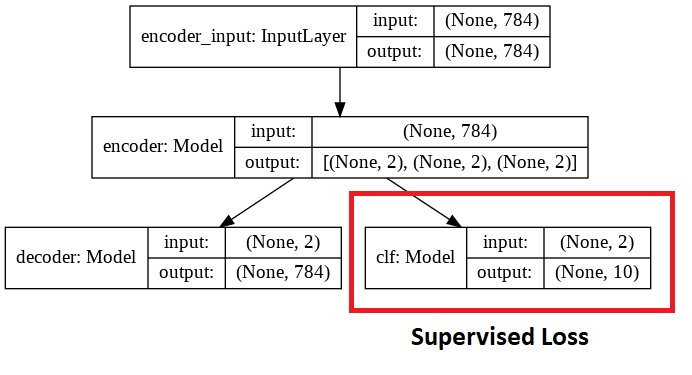

In [ ]:
import keras.backend as K
from keras import Model
from keras.layers import Input, Dense, Lambda
from keras.utils import plot_model
from keras.losses import binary_crossentropy

epochs = 30
batch_size = 32
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=original_dim, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Hasta aquí nada nuevo.

Ahora necesitamos crear un nuevo módulo que actúe como clasificador usando como `input` los valores del espacio latente.

Por tanto, necesitamos construir un clasificador y acoplarlo a la red. Tendrá como entrada `latent_dim` elementos, y (por ejemplo) una capa Densa con el número de neuronas correspondiente al número de clases existentes, en este caso, 10.

Luego, simplemente tendremos que conectarlo a nuestro modelo original.

In [ ]:
# New: add a classifier
clf_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_clf')
clf_outputs = Dense(10, activation='softmax', name='class_output')(clf_latent_inputs)
clf_supervised = Model(clf_latent_inputs, clf_outputs, name='clf')
clf_supervised.summary()
plot_model(clf_supervised, to_file='vae_clf.png', show_shapes=True)

Ahora debemos conectar el clasificador al VAE. Para ello, deberemos emplear por una parte las entradas (`inputs`) y por otra las dos salidas de las que disponemos: `decoder(encoder(inputs[2]))`, igual que hacíamos con el VAE básico, y `clf_supervised(encoder(inputs[2]))`, para que el clasificador intente clasificar los números usando la salida del encoder, es decir, el código latente.

In [ ]:
# instantiate VAE model
# New: Add another output
outputs = [decoder(encoder(inputs)[2]), clf_supervised(encoder(inputs)[2])]
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()
plot_model(vae, to_file='vae.png', show_shapes=True)

Si os fijáis, ya tenemos el módulo de clasificación conectado al VAE. Ahora podemos definir las pérdidas.

Por una parte tendrá las mismas que teía el VAE original:

In [ ]:
reconstruction_loss = binary_crossentropy(inputs, outputs[0])
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean((reconstruction_loss + kl_loss) /100.0)
vae.add_loss(vae_loss)

Pero además, tenemos que añadirle las pérdidas de clasificación.

**Ejercicio**

Añade el término de las pérdidas de clasificación. Puedes usar `vae.add_loss()` para añadir cualquier término de pérdidas al VAE. Ten en cuenta que `y_train.shape` es `(60000,)`, y que el número de clases es 10 (del 0 al 9). Por tanto, decide la función de pérdidas correcta en este caso. Es probable que necesites codificar las etiquetas de alguna forma para que funcione correctamente.

A la hora de compilar el modelo (`compile`) tendremos que indicarle que tenemos una nueva salida (`clf`) que queremos que entrene usando la función de pérdidas adecuada teniendo en cuenta que tenemo 10 clases.

Imaginémonos que la salida del módulo clasificador se llamase "salida" y que fuese un problema binario, es decir, que tuviésemos que usar la entropia binaria. Para ello, deberíamos indicarle a la función `compile` que `salida` se debe entrenar con la función `binary crossentropy`:

`vae.compile(optimizer='adam', loss={'salida': 'binary_crossentropy'})`

Además, cuando hagamos el `modelo.fit(...)`, deberemos indicarle los datos de entrada (`x_train`) y las etiquetas (en este caso, `y_train`). Esto lo conseguimos de una forma similar:

 `svae_history = vae.fit(x_train, {'clf': y_train},
        epochs=epochs,
        batch_size=batch_size)`

Esto es solo un ejemplo, adáptalo para que funcione con el VAE que estamos implementando.

In [ ]:
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

In [ ]:
# New: add the clf loss
vae.compile(optimizer='adam', loss={'clf': 'categorical_crossentropy'})

# reconstruction_loss = binary_crossentropy(inputs, outputs)
svae_history = vae.fit(x_train, {'clf': to_categorical(y_train)},
        epochs=epochs,
        batch_size=batch_size)

Por último, muestra ejemplos de imágenes muestreadas del espacio latente igual que hacíamos en el VAE básico:

In [ ]:
import matplotlib.pyplot as plt

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-3, 3]
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Y muestra el espacio latente:

In [ ]:
x_test_encoded_clf = encoder.predict(x_test, batch_size=32)
x_test_encoded_clf = np.asarray(x_test_encoded_clf)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_clf[2, :, 0], x_test_encoded_clf[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

Si lo comparamos con el espacio latente del VAE original:

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

**Pregunta**: ¿Qué cambios observas en el espacio latente?

**Respuesta**: En esta ocasión, al tener un término que le indica al VAE qué clase tiene cada imagen, es capaz de ordenarlas mejor en el espacio latente, lo que se traduce en una mayor calidad de generación, como habéis podido comprobar.

### Recursos interesantes:

- Fuente: https://www.linkedin.com/pulse/supervised-variational-autoencoder-code-included-ibrahim-sobh-phd

- [Variational Autoencoders](https://www.jeremyjordan.me/variational-autoencoders/)

- [Explicación en profundidad](https://jaketae.github.io/study/vae/)